In [1]:
library(tidyverse)

# Custom package
library(rutils)

-- Attaching packages ------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
projects <- c("CESC", "UCS", "UCEC")

In [3]:
# text_size <- 11
text_size <- 8
guide_size <- 1
family <- "ArialMT"
dpi <- 320
ht <- 9
wd_1 <- 5
wd_2 <- 3

In [4]:
q_thresh <- 0.05

In [5]:
demg_lists <- list()
deseq_dfs <- list()
for (dset_idx in 1:3) {
    demg_lists[[projects[dset_idx]]] <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_demg_list.txt"))
    deseq_dfs[[projects[dset_idx]]] <- read_tsv(paste0(dirs$analysis_dir, "/deg/", unified_dsets[dset_idx], "_DESeq_results.tsv")) %>%
        dplyr::rename(base_mean = baseMean, lfc = log2FoldChange) %>%
        dplyr::select(geneID, base_mean, lfc, qval)
}




-- Column specification ------------------------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  stat = col_double(),
  pvalue = col_double(),
  padj = col_double(),
  qval = col_double()
)



-- Column specification ------------------------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  stat = col_double(),
  pvalue = col_double(),
  padj = col_double(),
  qval = col_double()
)



-- Column specification ------------------------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  stat = col_double(),
  pvalue = col_double(),
  padj = col_double(

In [6]:
pbc_dfs <- list()
wa_dfs <- list()
en_mr_dfs <- list()

for (dset_idx in 1:3) {
    pbc_dfs[[projects[dset_idx]]] <- read_tsv(paste0(dirs$analysis_dir, "/feature_selection/", unified_dsets[dset_idx], "_pbc_results.tsv")) %>%
        dplyr::filter(geneID %in% demg_lists[[projects[dset_idx]]]) %>%
        condense_figo(include_pvals = TRUE) %>%
        dplyr::filter(figo_min_qval < q_thresh) %>%
        dplyr::inner_join(deseq_dfs[[projects[dset_idx]]], by = "geneID")

    wa_dfs[[projects[dset_idx]]] <- read_tsv(paste0(dirs$analysis_dir, "/feature_selection/", unified_dsets[dset_idx], "_welch_anova_results.tsv")) %>%
        dplyr::filter(geneID %in% demg_lists[[projects[dset_idx]]]) %>%
        dplyr::filter(qval < q_thresh) %>%
        dplyr::inner_join(deseq_dfs[[projects[dset_idx]]], by = "geneID")
    
    en_mr_dfs[[projects[dset_idx]]] <- read_tsv(paste0(dirs$analysis_dir, "/feature_selection/", unified_dsets[dset_idx], "_en_multinom_results.tsv")) %>%
        dplyr::filter(geneID %in% demg_lists[[projects[dset_idx]]]) %>%
        dplyr::inner_join(deseq_dfs[[projects[dset_idx]]], by = "geneID")    

    # Extra filtering since CESC has way more than the others & UCS has more than UCEC by a lot
    if (dset_idx == 1) {
        en_mr_dfs[[projects[dset_idx]]] <- en_mr_dfs[[projects[dset_idx]]] %>%
            arrange(qval) %>%
            top_n(qval, n = nrow(.) / 2)
    }
    else if (dset_idx == 2) {
        en_mr_dfs[[projects[dset_idx]]] <- en_mr_dfs[[projects[dset_idx]]] %>%
            arrange(qval) %>%
            top_n(qval, n = nrow(.) / 2)
    }
    else if (dset_idx == 3) {
        en_mr_dfs[[projects[dset_idx]]] <- en_mr_dfs[[projects[dset_idx]]] %>%
            arrange(qval) %>%
            top_n(qval, n = nrow(.) / 2)
    }

}


-- Column specification ------------------------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  figo_stage_1_pval = col_double(),
  figo_stage_2_pval = col_double(),
  figo_stage_3_pval = col_double(),
  figo_stage_4_pval = col_double(),
  figo_stage_1_qval = col_double(),
  figo_stage_2_qval = col_double(),
  figo_stage_3_qval = col_double(),
  figo_stage_4_qval = col_double(),
  figo_stage_1_cor = col_double(),
  figo_stage_2_cor = col_double(),
  figo_stage_3_cor = col_double(),
  figo_stage_4_cor = col_double()
)



-- Column specification ------------------------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  pval = col_double(),
  padj = col_double(),
  qval = col_double()
)



-- Column specification ------------------------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  figo_stag

In [7]:
pbc_gene_list <- purrr::map(pbc_dfs, "geneID") %>% unlist()
wa_gene_list <- purrr::map(wa_dfs, "geneID") %>% unlist()
en_mr_gene_list <- purrr::map(en_mr_dfs, "geneID") %>% unlist()
vis_gene_list <- pbc_gene_list %>%
    union(wa_gene_list) %>%
    union(en_mr_gene_list)

In [8]:
length(vis_gene_list)

[1] 92

# FIGO significance

In [9]:
figo_df <- tibble(geneID = vis_gene_list)
for (dset_idx in 1:3) {
    uv_col <- paste0(projects[dset_idx], "_uv")
    mv_col <- paste0(projects[dset_idx], "_mv")
    figo_df <- figo_df %>%
        mutate(
            !!as.name(uv_col) := geneID %in% pbc_dfs[[projects[dset_idx]]]$geneID | geneID %in% wa_dfs[[projects[dset_idx]]]$geneID,
            !!as.name(mv_col) := geneID %in% en_mr_dfs[[projects[dset_idx]]]$geneID
        )
}
figo_df <- figo_df %>%
    mutate(checks = rowSums(.[-1])) %>%
    select(geneID, checks, CESC_mv, CESC_uv, UCEC_mv, UCEC_uv, UCS_mv, UCS_uv) %>%
    mutate(last_true = max.col(.[,-c(1:2)], "last")) %>%
    arrange(checks, desc(last_true), desc(geneID)) %>%
    mutate(geneID_f = factor(geneID, levels = geneID)) %>%
    select(geneID, geneID_f, last_true, everything())

In [10]:
hm_figo_df <- figo_df %>%
    pivot_longer(cols = colnames(.[-c(1:4)]), names_to = "sig_list") %>%
    mutate(value = ifelse(value == TRUE, "yes", "no"), value = factor(value, levels = c("yes", "no")))

In [11]:
unique_sig_list <- unique(hm_figo_df$sig_list)
analysis_labs <- gsub("uv", "UV", gsub("mv", "MV", gsub("_", " ", unique_sig_list)))
names(analysis_labs) <- unique_sig_list

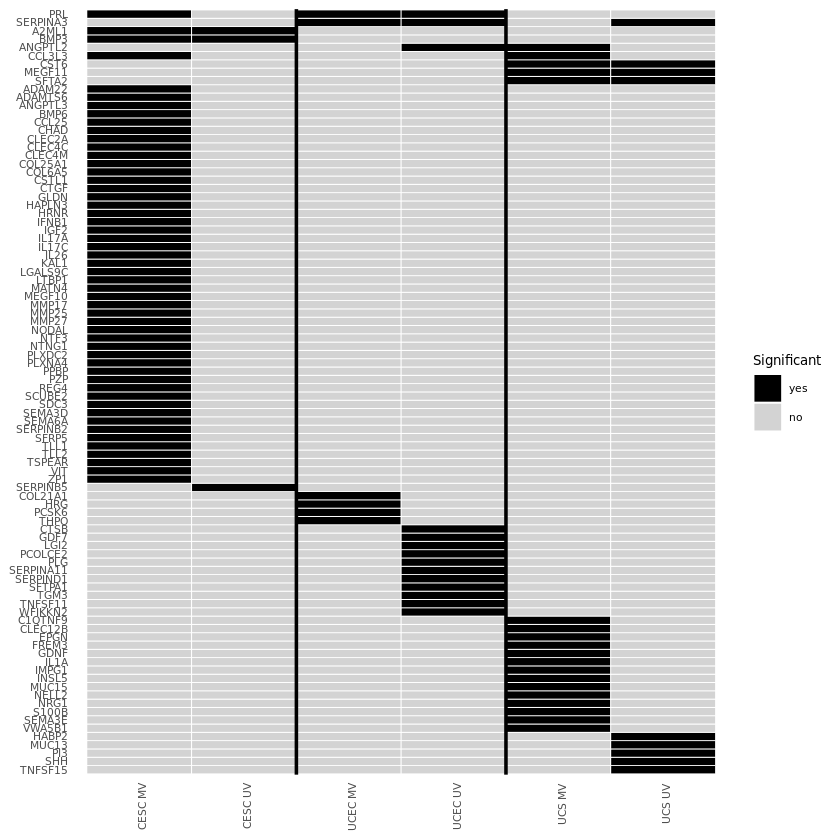

In [12]:
ggplot(hm_figo_df) +
    geom_tile(aes(x = sig_list, y = geneID_f, fill = value), color = "white", size = 0.25) +
    geom_vline(xintercept = c(2.5, 4.5), color = "black", size = 1) +
    scale_fill_manual(values = c("yes" = "black", "no" = "lightgray")) +
    theme_classic() +
    labs(x = NULL, y = NULL, fill = "Significant") +
    scale_x_discrete(labels = analysis_labs) +
    theme(
        text = element_text(size = text_size, family = family),
        axis.text.x = element_text(angle = 90, vjust = 0.9, hjust = 0.9),
        axis.line = element_blank(),
        axis.ticks = element_blank(),
    )

In [13]:
figo_subcat_hm <- last_plot()
ggsave(paste0(dirs$figures_dir, "/gene_lists/DE_figo_genes.png"), figo_subcat_hm, width = wd_1, height = ht, dpi = dpi)

# Directionality

In [14]:
dir_df <- tibble(geneID = vis_gene_list)
for (dset_idx in 1:3) {
    lfc_sign_col <- as.name(paste0(projects[dset_idx], "_sign"))
    proj_col <- as.name(projects[dset_idx])
    filt_deseq_df <- deseq_dfs[[projects[dset_idx]]] %>%
        dplyr::filter(geneID %in% vis_gene_list) %>%
        dplyr::mutate(!!lfc_sign_col := sign(lfc)) %>%
        dplyr::select(geneID, !!lfc_sign_col)
    dir_df <- dir_df %>%
        mutate(
#             !!as.name(projects[dset_idx]) := geneID %in% pbc_dfs[[projects[dset_idx]]]$geneID | geneID %in% wa_dfs[[projects[dset_idx]]]$geneID,
#             !!as.name(mv_col) := geneID %in% en_mr_dfs[[projects[dset_idx]]]$geneID,
            !!proj_col := geneID %in% Reduce(
                union,
                c(pbc_dfs[[projects[dset_idx]]]$geneID, wa_dfs[[projects[dset_idx]]]$geneID, en_mr_dfs[[projects[dset_idx]]]$geneID)
            )
        ) %>%
        dplyr::left_join(filt_deseq_df, by = "geneID") %>%
        mutate(!!lfc_sign_col := ifelse(!!proj_col, !!lfc_sign_col, 0))
}
dir_df <- dir_df %>%
    select(geneID, CESC_sign, UCEC_sign, UCS_sign) %>%
    rename(CESC = CESC_sign, UCEC = UCEC_sign, UCS = UCS_sign) %>%
    mutate(first_true = max.col(abs(.[,-1]), "first")) %>%
    mutate(checks = rowSums(abs(.[,2:4]))) %>%
    arrange(checks, desc(first_true), desc(geneID)) %>%
    mutate(geneID_f = factor(geneID, levels = geneID))

In [15]:
hm_dir_df <- dir_df %>%
    pivot_longer(cols = c("CESC", "UCEC", "UCS"), names_to = "sig_list", values_to = "de_dir") %>%
    mutate(de_dir = case_when(
        de_dir == 0 ~ "not present",
        de_dir == 1 ~ "up",
        de_dir == -1 ~ "down"
    ))

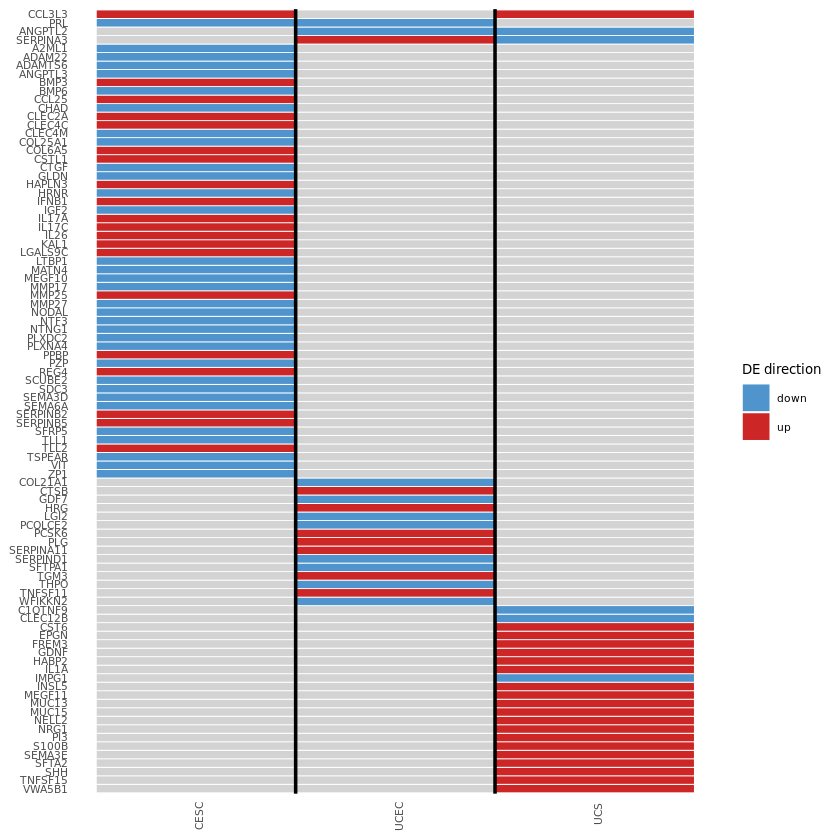

In [16]:
ggplot(data = hm_dir_df) +
    geom_tile(aes(x = sig_list, y = geneID_f, fill = de_dir), color = "white", size = 0.25) +
    geom_vline(xintercept = c(1.5, 2.5), color = "black", size = 1) +
    theme_classic() +
#     theme_bw() +
    scale_fill_manual(
        values = c("down" = "steelblue3", "not present" = "lightgray", "up" = "firebrick3"),
        breaks = c("down", "up")
    ) +
    theme(
        text = element_text(size = text_size, family = family),
        axis.text.x = element_text(angle = 90, vjust = 0.9, hjust = 0.9),
        axis.line = element_blank(),
        axis.ticks = element_blank(),
    ) +
    labs(y = NULL, x = NULL, fill = "DE direction")

In [17]:
figo_hm <- last_plot()
ggsave(paste0(dirs$figures_dir, "/gene_lists/DE_dir_figo_genes.png"), figo_hm, width = wd_2, height = ht, dpi = dpi)

In [18]:
save(
    list = c("figo_hm", "figo_subcat_hm"),
    file = paste0(dirs$figures_dir, "/saved_obj/figo_hms.RData")
)